# Amazon SageMaker Clarifyを用いたデータバイアス検知


## Amazon Science: _[How Clarify helps machine learning developers detect unintended bias](https://www.amazon.science/latest-news/how-clarify-helps-machine-learning-developers-detect-unintended-bias)_ 

[<img src="img/amazon_science_clarify.png"  width="100%" align="left">](https://www.amazon.science/latest-news/how-clarify-helps-machine-learning-developers-detect-unintended-bias)

# 用語集
https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-data-bias.html

* **バイアス**:
年齢や収入層などの異なるグループ間で、学習データやモデルの予測動作に生じる不均衡のこと。バイアスは、モデルの学習に使用したデータやアルゴリズムから生じることがあります。例えば、MLモデルが主に中高年のデータで学習された場合、若年層や高齢者に対する予測を行う際に精度が低くなる可能性があります。

* **バイアスメトリクス**: 
潜在的なバイアスの度合いを示す数値を返す関数。

* **バイアスレポート**:
分析対象のデータセット、またはデータセットとモデルの組み合わせに対するバイアスメトリクスのコレクション。

* **ラベル**:
機械学習モデルのトレーニングのターゲットとなる特徴量。

* **ポジティブラベル値**:
サンプル内の特定の人口集団（年代、性別など）でよく観測されるラベル値。言い換えれば、サンプルがポジティブな結果を持つことを示しています。

* **ネガティブラベル値**:
サンプル内の特定の人口集団（年代、性別など）であまり観測されないラベル値。言い換えれば、サンプルがネガティブな結果を持つことを示しています。

* **ファセット**:
バイアスの分析対象となる属性を含むカラムまたは特徴量のこと。（訳注: 例えばデータセットに男女間の差異がないかを分析したい場合は、「性別」のカラムがファセット（側面）となります。）

* **ファセット値**:
バイアスが含まれ得る属性の特徴値。

# トレーニング前バイアスメトリクス
https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-data-bias.html

* **クラス不均衡、Class Imbalance (CI)**:
異なるファセット値間のサンプル数の不均衡を測定。（訳注: 男女のサンプル数に不均衡がないか、など）

* **正例ラベル比率の差、Difference in Proportions of Labels (DPL)**:
異なるファセット値間でポジティブなラベル比率の不均衡を測定。（訳注: 国籍によってローンの審査の通過率に不均衡がないか、など）

* **カルバック・ライブラー・ダイバージェンス、Kullback-Leibler Divergence (KL)**:
異なるファセットのラベル分布がエントロピー的にどの程度乖離しているかを測定。

* **イェンセン・シャノン・ダイバージェンス、Jensen-Shannon Divergence (JS)**:
異なるファセットのラベル分布がエントロピー的にどの程度乖離しているかを測定。

* **Lpノルム、Lp-norm (LP)**:
データセット内の異なるファセットのラベル分布同士のpノルム差を測定。

* **Total Variation Distance (TVD)**:
データセット内の異なるファセットのラベル分布同士のL1ノルムの半分を測定。

* **Kolmogorov-Smirnov (KS)**:
データセット内の異なるファセットのラベル分布同士の最大ダイバージェンスを測定。

* **Conditional Demographic Disparity (CDD)**:
あるファセットのポジティブとネガティブのラベル比率の差異をサブグループごとに測定。

In [21]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

import botocore.config

config = botocore.config.Config(
    user_agent_extra='dsoaws/1.0'
)

sm = boto3.Session().client(service_name="sagemaker", 
                            region_name=region,
                            config=config)

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

# データセットの分析

各商品カテゴリーのPandas DataFrameを作成します。

## データセットカラムの説明
- `marketplace`: 二文字の国コード（今回はすべて「US」）。
- `customer_id`: それぞれの書き手のレビュー集約に使われるランダムID。
- `review_id`: レビューのユニークID。
- `product_id`: Amazon標準識別番号（ASIN）。`http://www.amazon.com/dp/<ASIN>` が商品の詳細ページへのリンクとなる。
- `product_parent`: ASINの親。ひとつの親に対して複数のASINが存在しうる（同じ商品の色違いやフォーマット違いなど）。
- `product_title`: 商品のタイトル表記。
- `product_category`: レビューのグループ化に使う大まかな商品カテゴリー（このケースでは「デジタルビデオ」など）
- `star_rating`: レビューの星評価（1〜5）。
- `helpful_votes`: レビューへの「役に立った」投票の個数。
- `total_votes`: レビューへの全投票数。
- `vine`: レビューが[Vine](https://www.amazon.com/gp/vine/help)先取りプログラムの一環で書かれたか否か。
- `verified_purchase`: レビューが検証済みの購入対するものか否か。
- `review_headline`: レビューそのもののタイトル。
- `review_body`: レビュー本体のテキスト。
- `review_date`: レビューが投稿された日付。
- `year`: レビュー投稿日付から取得した年情報。

In [23]:
import csv

df_giftcards = pd.read_csv(
    "./data-clarify/amazon_reviews_us_Gift_Card_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)

df_software = pd.read_csv(
    "./data-clarify/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)

df_videogames = pd.read_csv(
    "./data-clarify/amazon_reviews_us_Digital_Video_Games_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)

df = pd.concat([df_giftcards, df_software, df_videogames], ignore_index=True, sort=False)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,24371595,R27ZP1F1CD0C3Y,B004LLIL5A,346014806,Amazon eGift Card - Celebrate,Gift Card,5,0,0,N,Y,Five Stars,Great birthday gift for a young adult.,2015-08-31
1,US,42489718,RJ7RSBCHUDNNE,B004LLIKVU,473048287,Amazon.com eGift Cards,Gift Card,5,0,0,N,Y,Gift card for the greatest selection of items ...,It's an Amazon gift card and with over 9823983...,2015-08-31
2,US,861463,R1HVYBSKLQJI5S,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,5,0,0,N,Y,Five Stars,Good,2015-08-31
3,US,25283295,R2HAXF0IIYQBIR,B00IX1I3G6,926539283,Amazon.com Gift Card Balance Reload,Gift Card,1,0,0,N,Y,One Star,Fair,2015-08-31
4,US,397970,RNYLPX611NB7Q,B005ESMGV4,379368939,"Amazon.com Gift Cards, Pack of 3 (Various Desi...",Gift Card,5,0,0,N,Y,Five Stars,I can't believe how quickly Amazon can get the...,2015-08-31


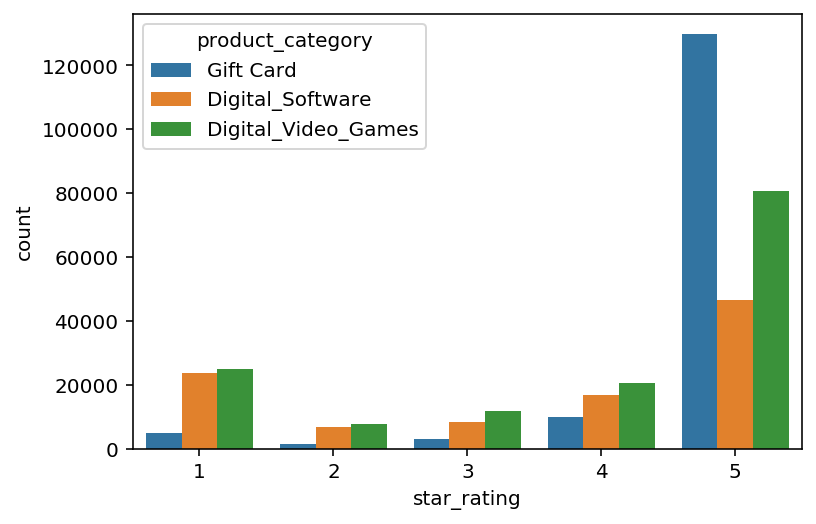

In [24]:
import seaborn as sns

sns.countplot(data=df, x="star_rating", hue="product_category")

### データのアップロード

In [25]:
!mkdir -p ./transformed/

path = "./amazon_reviews_us_giftcards_software_videogames.csv"
df.to_csv(path, index=False, header=True)

data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="bias/transformed", path=path)
data_s3_uri

's3://sagemaker-us-east-1-809078683005/bias/transformed/amazon_reviews_us_giftcards_software_videogames.csv'

# バイアス分析

### `DataConfig` のセットアップ

In [26]:
from sagemaker import clarify

bias_s3_prefix = "bias/generated_bias_report"
bias_report_output_path = "s3://{}/{}/data".format(bucket, bias_s3_prefix)

data_config = clarify.DataConfig(
    s3_data_input_path=data_s3_uri,
    s3_output_path=bias_report_output_path,
    label="star_rating",
    headers=df.columns.to_list(),
    dataset_type="text/csv",
)

### `BiasConfig` のセットアップ

SageMaker Clarifyでは、分析対象のカラム（`facets`）と何が望ましい結果なのか（`label_values_or_threshold`）を教えてあげる必要があります。

これらの情報は `BiasConfig` API で指定します。ここでは `star_rating==5` と `star_rating==4` が望ましい結果となります。`product_category` が今回分析するファセットです。

In [8]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5, 4], 
    facet_name="product_category"
)

### SageMaker Clarify Processing Jobのセットアップ

In [9]:
processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.m5.xlarge", 
    sagemaker_session=sess
)

### Processing Jobを実行

In [10]:
processor.run_pre_training_bias(
    data_config=data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-10-18-09-46-39-294
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-809078683005/bias/transformed/amazon_reviews_us_giftcards_software_videogames.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [11]:
bias_processing_job_name = processor.latest_job.job_name
print(bias_processing_job_name)

Clarify-Pretraining-Bias-2021-10-18-09-46-39-294


In [12]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, bias_processing_job_name
        )
    )
)

In [13]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, bias_processing_job_name
        )
    )
)

In [14]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix={}/">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, region, bias_s3_prefix
        )
    )
)

In [15]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=bias_processing_job_name, sagemaker_session=sess
)

### _このセルの実行には5〜10分程度かかります。_

In [16]:
%%time

running_processor.wait(logs=False)

.................................................!CPU times: user 187 ms, sys: 24.5 ms, total: 212 ms
Wall time: 4min 6s


### バイアスレポートを読む

In [17]:
!aws s3 ls $bias_report_output_path/

2021-10-18 09:51:29       5473 analysis.json
2021-10-18 09:46:40        540 analysis_config.json
2021-10-18 09:51:29     315830 report.html
2021-10-18 09:51:29      45729 report.ipynb
2021-10-18 09:51:29      65203 report.pdf


In [18]:
!aws s3 cp --recursive $bias_report_output_path ./generated_bias_report/data/

download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data/analysis_config.json to generated_bias_report/data/analysis_config.json
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data/analysis.json to generated_bias_report/data/analysis.json
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data/report.pdf to generated_bias_report/data/report.pdf
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data/report.ipynb to generated_bias_report/data/report.ipynb
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data/report.html to generated_bias_report/data/report.html


In [19]:
from IPython.core.display import display, HTML

display(
    HTML('<b>Review <a target="blank" href="./generated_bias_report/data/report.html">Unbalanced Bias Report</a></b>')
)

# `product_category` と `star_rating` に対してデータセットをバランス化

In [27]:
df_group_by = df.groupby(["product_category", "star_rating"])
df_balanced_data = df_group_by.apply(lambda x: x.sample(df_group_by.size().min()).reset_index(drop=True))

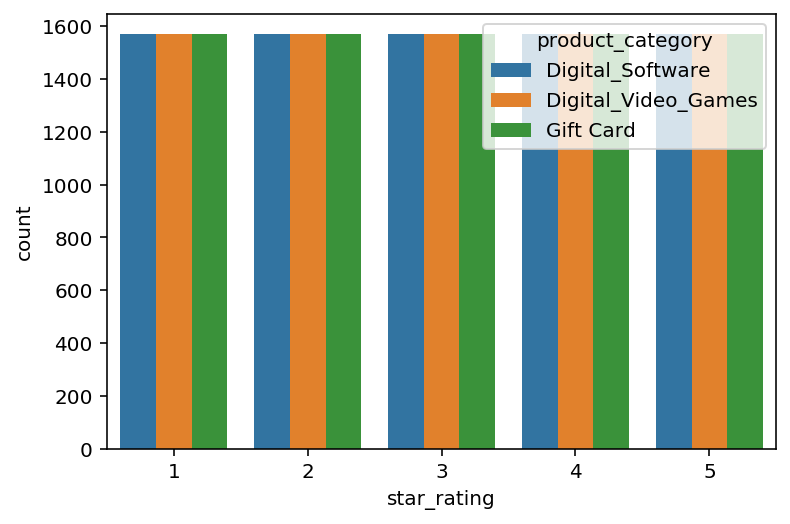

In [28]:
import seaborn as sns

sns.countplot(data=df_balanced_data, x="star_rating", hue="product_category")

# SageMaker Clarifyを用いてバランス化したデータセットのバイアスを分析

In [29]:
path_balanced = "./amazon_reviews_us_giftcards_software_videogames_balanced.csv"
df_balanced_data.to_csv(path_balanced, index=False, header=True)

balanced_data_s3_uri = sess.upload_data(bucket=bucket, key_prefix="bias/data_balanced", path=path_balanced)
balanced_data_s3_uri

's3://sagemaker-us-east-1-809078683005/bias/data_balanced/amazon_reviews_us_giftcards_software_videogames_balanced.csv'

In [30]:
from sagemaker import clarify

bias_s3_prefix = "bias/generated_bias_report"
bias_report_balanced_output_path = "s3://{}/{}/data_balanced".format(bucket, bias_s3_prefix)

balanced_data_config = clarify.DataConfig(
    s3_data_input_path=balanced_data_s3_uri,
    s3_output_path=bias_report_balanced_output_path,
    label="star_rating",
    headers=df_balanced_data.columns.to_list(),
    dataset_type="text/csv",
)

### `BiasConfig` のセットアップ
SageMaker Clarify also needs the sensitive columns (`facets`) and the desirable outcomes (`label_values_or_threshold`).

We specify this information in the `BiasConfig` API. Here that the positive outcome is `star_rating==5` and `star_rating==4`.  `product_category` is the facet that we analyze in this run.

In [31]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[5, 4], 
    facet_name="product_category" 
)

### SageMaker Clarify Processing Jobのセットアップ

In [32]:
processor = clarify.SageMakerClarifyProcessor(
    role=role, 
    instance_count=1, 
    instance_type="ml.m5.xlarge", 
    sagemaker_session=sess
)

In [33]:
processor.run_pre_training_bias(
    data_config=balanced_data_config, 
    data_bias_config=bias_config, 
    methods=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"],
    wait=False, 
    logs=False
)


Job Name:  Clarify-Pretraining-Bias-2021-10-18-23-31-52-678
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-809078683005/bias/data_balanced/amazon_reviews_us_giftcards_software_videogames_balanced.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data_balanced/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data_balanced', 'LocalPath': '/opt/ml/processing/output', 'S3Uplo

In [34]:
balanced_bias_processing_job_name = processor.latest_job.job_name
print(balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2021-10-18-23-31-52-678


In [35]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">Processing Job</a></b>'.format(
            region, balanced_bias_processing_job_name
        )
    )
)

In [36]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch Logs</a> After About 5 Minutes</b>'.format(
            region, balanced_bias_processing_job_name
        )
    )
)

In [37]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}?region={}&prefix={}/">S3 Output Data</a> After The Processing Job Has Completed</b>'.format(
            bucket, region, bias_s3_prefix
        )
    )
)

In [38]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=balanced_bias_processing_job_name, sagemaker_session=sess
)

### _このセルの実行には5〜10分程度かかります。_

In [39]:
%%time

running_processor.wait(logs=False)

...............................................................!CPU times: user 253 ms, sys: 12.8 ms, total: 266 ms
Wall time: 5min 16s


### バランス化したデータセットのバイアスレポートを分析

なお、クラス不均衡のメトリクスは、ターゲットラベルに対してすべての商品カテゴリーで同じ値になっています。

S3から生成されたバイアスレポートをダウンロード

In [40]:
!aws s3 ls $bias_report_balanced_output_path/

2021-10-18 23:37:06       5188 analysis.json
2021-10-18 23:31:53        540 analysis_config.json
2021-10-18 23:37:06     312901 report.html
2021-10-18 23:37:06      42800 report.ipynb
2021-10-18 23:37:06      63030 report.pdf


In [41]:
!aws s3 cp --recursive $bias_report_balanced_output_path ./generated_bias_report/data_balanced/

download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data_balanced/analysis_config.json to generated_bias_report/data_balanced/analysis_config.json
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data_balanced/report.pdf to generated_bias_report/data_balanced/report.pdf
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data_balanced/report.ipynb to generated_bias_report/data_balanced/report.ipynb
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data_balanced/analysis.json to generated_bias_report/data_balanced/analysis.json
download: s3://sagemaker-us-east-1-809078683005/bias/generated_bias_report/data_balanced/report.html to generated_bias_report/data_balanced/report.html


In [42]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="./generated_bias_report/data_balanced/report.html">Balanced Bias Report</a></b>'
    )
)

# リソースを解放

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>